In [1]:
%matplotlib inline
import cv2
import matplotlib.pyplot as plt
import numpy as np
import time
from IPython import display

## Generate **skymask**

We assume that images have rows of pixels at the top which contain nothing but sky.
Our objective is to mask to sky. This mask is a binary, **skymask**, in which each pixel has one of
two possible values representing **sky** (255) or **not sky** (0). 

Steps:

1. Import original color image and apply a Gaussian mask to reduce noise
2. Convert the image to grayscale
3. Using the grayscale image, find rows which contain nothing but sky.
4. Using the color image, calculate the color boundaries for pixels in rows containing nothing but sky.
5. Segment the color image into *sky* and *not sky* using the color boundaries as arguments for the cv2inRange function.

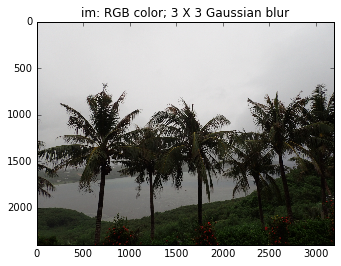

In [2]:
# Step 1: Import original color image and apply a Gaussian mask to reduce noise

im = cv2.imread('test1.JPG')
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
im = cv2.GaussianBlur(im, (3, 3), 0)
#plt.imshow(im)
plt.imshow(im)
plt.title('im: RGB color; 3 X 3 Gaussian blur')
res = plt.show()

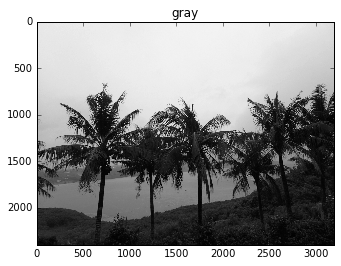

In [3]:
# Step 2: Convert the image to grayscale

im_gray = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
plt.imshow(im_gray, cmap=plt.cm.gray)
plt.title('gray')
res = plt.show()

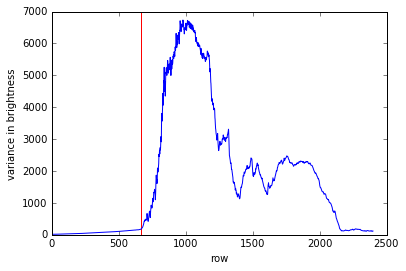

In [4]:
# Step 3; Using the grayscale image, find rows which contain nothing but sky.

# Calculate variance of pixel values for each row
pvar = im_gray.var(1)

# Find inflection point
dpvar = np.diff(pvar)

dpvar_threshold = 5.0
for i in range(len(dpvar)):
    if dpvar[i] > dpvar_threshold:
        break
max_sky_row = i-5

plt.plot(pvar)
plt.xlabel('row')
plt.ylabel('variance in brightness')
plt.vlines(max_sky_row, 0, 7000, color='r', linestyle='solid')
res = plt.show()

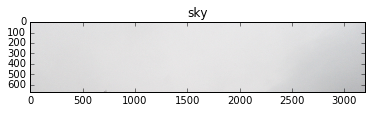

Lower color boundary:  [139 134 143]    Upper color boundary:  [236 234 238]


In [5]:
# Step 4: Using the color image, calculate the color boundaries for pixels in rows containing nothing but sky.

sky_sample = im[0:max_sky_row, 0:im.shape[1]]
plt.imshow(sky_sample)
plt.title('sky')
res = plt.show()

# Find boundaries
pixels = sky_sample.reshape(-1, 3) # pixels are now in an array with 3 columns (BGR)
lower = pixels.min(axis=0)              # lower boundary (BGR)
upper = pixels.max(axis=0)              # upper boundary (BGR)
print('Lower color boundary: ', lower, '   Upper color boundary: ', upper)

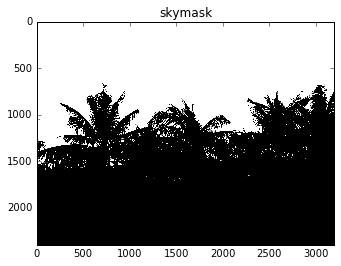

In [6]:
# Step 5: Segment the color image into sky and not sky using the color boundaries as arguments 
# for the cv2inRange function.

skymask = cv2.inRange(im, lower, upper)
plt.imshow(skymask, cmap=plt.cm.gray)
plt.title('skymask')
plt.show()

Last all-white row: 666    First all-black row: 1897


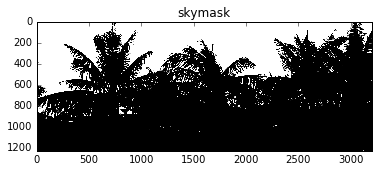

In [7]:
# Step 6: Remove all-white rows at top of skymask and all-black rows at bottom of skymask.

rowmeans = skymask.mean(1)
rowindices = range(len(rowmeans))

last_white_row = 0
for i in rowindices:
    if rowmeans[i] != 255.0:
        last_white_row = i-1
        break

first_black_row = len(rowmeans)
for i in reversed(rowindices):
    if rowmeans[i] != 0.0:
        first_black_row = i+1
        break 
        
print('Last all-white row:', last_white_row, '   First all-black row:',first_black_row)

skymask = skymask[last_white_row:first_black_row, 0:skymask.shape[1]]
plt.imshow(skymask, cmap=plt.cm.gray)
plt.title('skymask')
plt.show()
res = cv2.imwrite('skymask.png', skymask)

## Scan skymask for coconut rhinoceros beetle damage

In [8]:
# Code for these helper functions was gleened from PyImageSearch blogs.

def resize(image, width=None, height=None, inter=cv2.INTER_AREA):
    # initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    (h, w) = image.shape[:2]

    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return image

    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)

    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(w)
        dim = (width, int(h * r))

    # resize the image
    resized = cv2.resize(image, dim, interpolation=inter)

    # return the resized image
    return resized


def pyramid(image, scale=1.5, minSize=(30, 30)):
    # yield the original image
    yield image

    # keep looping over the pyramid
    while True:
        # compute the new dimensions of the image and resize it
        w = int(image.shape[1] / scale)
        image = resize(image, width=w)

        # if the resized image does not meet the supplied minimum
        # size, then stop constructing the pyramid
        if image.shape[0] < minSize[1] or image.shape[1] < minSize[0]:
            break

        # yield the next image in the pyramid
        yield image

def sliding_window(image, stepSize, windowSize):
    # slide a window across the image
    for y in range(0, image.shape[0], stepSize):
        for x in range(0, image.shape[1], stepSize):
            # yield the current window
            yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])

In [9]:
# load the image and define the window width and height

image = skymask
(winW, winH) = (256, 256)

# loop over the image pyramid
i = 0
for resized in pyramid(image, scale=1.5):
    print(resized.shape)
    # loop over the sliding window for each layer of the pyramid
    for (x, y, window) in sliding_window(resized, stepSize=32, windowSize=(winW, winH)):

        # if the window does not meet our desired window size, ignore it
        if window.shape[0] != winH or window.shape[1] != winW:
            continue

        # THIS IS WHERE YOU WOULD PROCESS YOUR WINDOW, SUCH AS APPLYING A
        # MACHINE LEARNING CLASSIFIER TO CLASSIFY THE CONTENTS OF THE
        # WINDOW

        # since we do not have a classifier, we'll just draw the window
        #clone = resized.copy()
        #cv2.rectangle(clone, (x, y), (x + winW, y + winH), (0, 255, 0), 2)
        #cv2.rectangle(clone, (x, y), (x + winW, y + winH), 128, 10)
        i += 1
        cv2.imwrite('p/'+str(i)+'.png', resized[y:y+winH, x:x+winW])
        
        #plt.title(i)
        #plt.close()
        #plt.imshow(clone, cmap=plt.cm.gray) 
        #display.display(plt.gcf())
        #display.clear_output(wait=True)
        #time.sleep(0.025)

(1231, 3200)
(820, 2133)
(546, 1422)
(364, 948)
(242, 632)
(161, 421)
(107, 280)
(71, 186)
(47, 124)
(31, 82)
